In [71]:
import pandas as pd
df=df=pd.read_csv('C:/Users/trainees/Desktop/AllData/data/Classificationtable.csv')
df.shape

(474, 10)

In [72]:
from io import StringIO
col = ['Category', 'tokenized_source']
df = df[col]
df = df[pd.notnull(df['tokenized_source'])]
df.columns = ['Category', 'tokenized_source']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.shape

(244, 3)

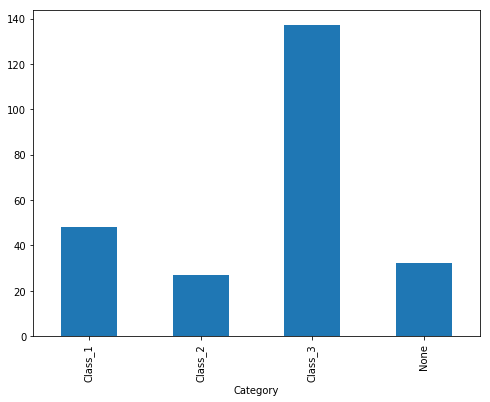

In [73]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Category').tokenized_source.count().plot.bar(ylim=0)
plt.show()

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.tokenized_source).toarray()
labels = df.category_id
features.shape

(244, 2372)

In [75]:
category_to_id

{'Class_1': 0, 'Class_2': 3, 'Class_3': 1, 'None': 2}

In [76]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Class_1':
  . Most correlated unigrams:
. electronics
. technology
  . Most correlated bigrams:
. web design
. phone email
# 'Class_2':
  . Most correlated unigrams:
. defense
. rescue
  . Most correlated bigrams:
. led lighting
. website home
# 'Class_3':
  . Most correlated unigrams:
. safety
. tools
  . Most correlated bigrams:
. hand tools
. cutting tools
# 'None':
  . Most correlated unigrams:
. try
. rust
  . Most correlated bigrams:
. line card
. contact privacy


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['tokenized_source'], df['Category'], random_state = 0,shuffle=True)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [78]:
X_test.shape

(61,)

In [79]:
y_test.shape

(61,)

In [80]:
print(clf.predict(count_vect.transform(["  Corporate Values Hybridized Micro Grid News & Press Advanced Lithium-ion Battery Technology Products case studies Mission Critical Power Model 8224S 24Vdc Lithium Ion Battery Module Frequently Asked Questions (FAQs) Markets and Applications Loving Monday Events Resources Customer Portal Literature About Beckett sales beckettenergy com 440 353 6300 News Press Contact Us Search for Menu Skip to content Markets and Applications Maritime Robotics Specialized Vehicles Material Handling Equipment Mission Critical Power Auxiliary Power Units Hybridized Micro Grid Stationary Energy Storage Systems Products Advanced Technology Batteries Model 8224S 24Vdc Lithium Ion Battery Module Model 8124S Stand Alone Lithium ion Energy System Battery Management Systems Model 84BMS Battery Management System Controller Resources How to Build a Large Lithium Ion Battery Pack for Commercialization Lithium ion Battery Safety Why Lithium ion Batteries Events Literature Frequently Asked Questions FAQs Partnerships Industry Affiliations Glossary About Beckett Corporate Values Family of Companies Loving Monday Careers About Download How to build a large lithium ion battery White Paper See what our customers are doing Visit Case Studies Tell us about your application Customer Portal Get access to advanced application tools Advanced Energy Lithium ion Battery Solutions Advanced Technology Batteries Model 8224S 24Vdc Lithium Ion Battery Module Model 8124S Stand Alone Lithium ion Energy System Battery Management Systems Model 84BMS Battery Management System Controller Follow us About Beckett About Beckett Energy Systems Beckett Energy Systems is a division of R W Beckett Corporation Leveraging Beckett â€™ s 75 years of engineering commercialization and manufacturing expertise we strive to passionately serve our customers as we expand into the electricity storage and other energy product markets Values We Live By Integrity Excellence and a Profound Respect for the Individual Our Mission Grow Relentlessly Improve Passionately Serve our Customers and Fellow Employees Family of Companies We are part of the Beckett family of companies Beckett â€™ s core values are centrally reflected by each of our firms Throughout our companies we have competencies in precision metal engineering and fabrication combustion light assembly and electronics design and manufacturing Beckett products can be found in over 40 million residential and commercial structures in the U S and abroad Â© Beckett Energy Systems a division of R W Beckett Corp All rights reserved 38251 Center Ridge Rd North Ridgeville OH 44039 440 353 6300 Sitemap Privacy Policy News Press Contact Us Do NOT follow this link or you will be banned from the site Beckett Energy Systems harnesses the best of today â€™ s advanced battery technology to meet the energy power and storage requirements of innovative applications Advanced energy storage Advanced battery technology"])))

['Class_3']


In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

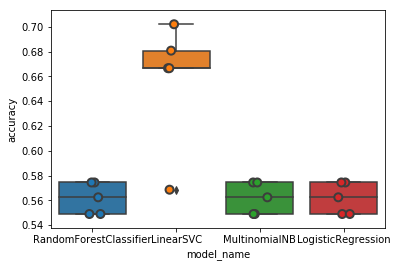

In [82]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [83]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.656988
LogisticRegression        0.561895
MultinomialNB             0.561895
RandomForestClassifier    0.561895
Name: accuracy, dtype: float64

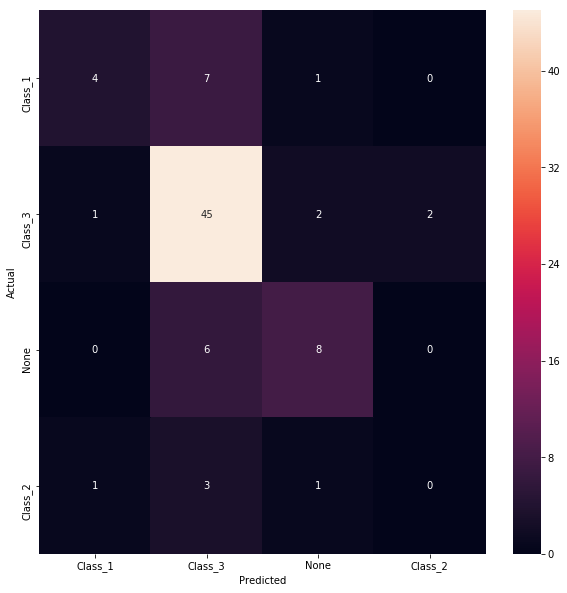

In [84]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [85]:
from IPython.display import display
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 0:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Category', 'tokenized_source']])
            print('')

'Class_3' predicted as 'Class_1' : 1 examples.


,Category,tokenized_source
19,Class_3,Ethernet to Fiber Optic Converters Site Map ...



'None' predicted as 'Class_1' : 0 examples.


,Category,tokenized_source



'Class_2' predicted as 'Class_1' : 1 examples.


,Category,tokenized_source
309,Class_2,skype:USAPaxton.support Svenska Why use Paxt...



'Class_1' predicted as 'Class_3' : 7 examples.


,Category,tokenized_source
127,Class_1,Quality Assurance Read More About Our Produc...
385,Class_1,Login Terms & Conditions Technical Docs Cont...
430,Class_1,Villager 4 x 2 Rentals Centrifugal Pumps Nex...
37,Class_1,Door Lock EnerSys/Hawker > Meet Team Dantona...
207,Class_1,Car Electronics bluetooth Search by Product ...
176,Class_1,Call Now for pricing! Contact Us Gallery fno...
255,Class_1,Email. sales@komelonusa.com sales@komelonusa...



'None' predicted as 'Class_3' : 6 examples.


,Category,tokenized_source
362,None,BLOG m.bills@safetydecals.com CONTACT PRIVAC...
363,None,FAQ Roll Goods Contact Us Helpful Links Helm...
204,None,Key Lighting Sites Line Card Blog Home Socia...
33,None,New Website Testimonial Policies Parts Catal...
225,None,Specimen Dies Contact Us Specimen Presses Sp...
35,None,PRODUCTS Shop Products Contact Us News Tel: ...



'Class_2' predicted as 'Class_3' : 3 examples.


,Category,tokenized_source
288,Class_2,Model 4500.540 Model 2500.540HI 3B-B Hand To...
382,Class_2,EB-2U Descent Chair System Choctaw-Kaul Dist...
303,Class_2,info@orangeinstruments.com Best sellers OEM ...



'Class_1' predicted as 'None' : 1 examples.


,Category,tokenized_source
211,Class_1,Our Work HT Micro Technology Contact Us Rose...



'Class_3' predicted as 'None' : 2 examples.


,Category,tokenized_source
208,Class_3,Host Engineering Inc Industrial Automation Pr...
9,Class_3,LA36400 Shopping Cart DH361R My Wishlist DE3...



'Class_2' predicted as 'None' : 1 examples.


,Category,tokenized_source
42,Class_2,LED Suspended ABOUT US RAPID SHIP Tunable LE...



'Class_1' predicted as 'Class_2' : 0 examples.


,Category,tokenized_source



'Class_3' predicted as 'Class_2' : 2 examples.


,Category,tokenized_source
148,Class_3,View other Fox Product Literature Use the Pr...
125,Class_3,Defense SERVICES Entertainment New Energy Me...



'None' predicted as 'Class_2' : 0 examples.


,Category,tokenized_source


In [86]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Category))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'None':
  . Top unigrams:
       . technology
       . electronics
  . Top bigrams:
       . web design
       . phone email
# 'None':
  . Top unigrams:
       . maintenance
       . rescue
  . Top bigrams:
       . led lighting
       . contact contact
# 'None':
  . Top unigrams:
       . tools
       . safety
  . Top bigrams:
       . safety training
       . shop contact
# 'None':
  . Top unigrams:
       . rust
       . faq
  . Top bigrams:
       . contact privacy
       . products contact


In [87]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

             precision    recall  f1-score   support

    Class_1       0.67      0.33      0.44        12
    Class_3       0.74      0.90      0.81        50
       None       0.67      0.57      0.62        14
    Class_2       0.00      0.00      0.00         5

avg / total       0.67      0.70      0.67        81

